In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-11-16 17:30:02,377 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = develop  (spdm=develop extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-11-16T17:30:02.377146.
 Job ID: fytok_salmon_surface_2685

#######################################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    time=2.30,
    core_transport={"model": [{"code": {"name": "dummy"}}]},
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
        ]
    },
    transport_solver={
        "code": {
            # "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 250,
                "equations": {
                    "ion/D/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/T/density_thermal": {
                        "profile": 1.5e19,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [2.0e19]},
                        ],
                    },
                    "ion/D/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "ion/T/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                    "electrons/temperature": {
                        "profile": 1000,
                        "boundary_condition": [
                            {"identifier": {"index": 2}, "value": [0]},
                            {"identifier": {"index": 1}, "value": [1000]},
                        ],
                    },
                },
            },
        }
    },
)

2023-11-16 17:30:02,609 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-16 17:30:02,664 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.refresh()

2023-11-16 17:30:03,054 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-16 17:30:03,059 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_sources.source.dummy
2023-11-16 17:30:03,065 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy
2023-11-16 17:30:03,070 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.transport_solver_numerics.fy_trans


In [4]:
eq_1d=tokamak.equilibrium.time_slice[0].profiles_1d

In [5]:
type(eq_1d)

fytok.plugins.equilibrium.fy_eq.FyEquilibriumProfiles1D

2023-11-16 17:30:03,113 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib


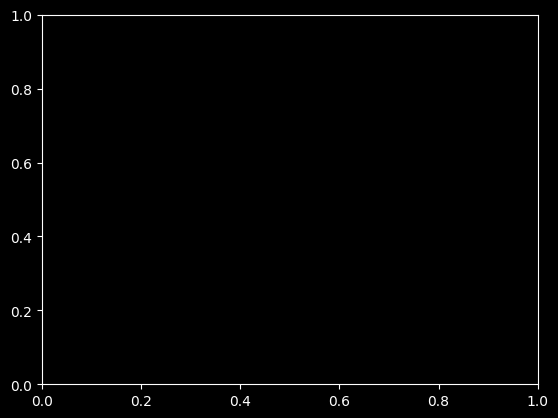

In [6]:
eq_1d.grid

In [7]:
tokamak.update_core_profiles()
# boundary_condition={
#     "ion/D/density_thermal": [[0.0], [2.0e19]],
#     "ion/T/density_thermal": [[0.0], [2.0e19]],
#     "ion/D/temperature": [[0.0], [1000]],
#     "ion/T/temperature": [[0.0], [1000]],
#     "electrons/temperature": [[0.0], [1000]],
# },


2023-11-16 17:30:03,358 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans.py:583:execute: Execute N/A None {'rho_tor_norm': array([0.01      , 0.01775591, 0.02551181, 0.03326772, 0.04102362,
       0.04877953, 0.05653543, 0.06429134, 0.07204724, 0.07980315,
       0.08755906, 0.09531496, 0.10307087, 0.11082677, 0.11858268,
       0.12633858, 0.13409449, 0.14185039, 0.1496063 , 0.1573622 ,
       0.16511811, 0.17287402, 0.18062992, 0.18838583, 0.19614173,
       0.20389764, 0.21165354, 0.21940945, 0.22716535, 0.23492126,
       0.24267717, 0.25043307, 0.25818898, 0.26594488, 0.27370079,
       0.28145669, 0.2892126 , 0.2969685 , 0.30472441, 0.31248031,
       0.32023622, 0.32799213, 0.33574803, 0.34350394, 0.35125984,
       0.35901575, 0.36677165, 0.37452756, 0.38228346, 0.39003937,
       0.39779528, 0.40555118, 0.41330709, 0.42106299, 0.4288189 ,
       0.4365748 , 0.44433071, 0.45208661, 0.45984252, 0.46759843,
       0.4753543

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
solver_1d = tokamak.transport_solver.time_slice.current.solver_1d
fig = sp_view.plot(
    sum(
        [
            [
                (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                # (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                # (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

In [ ]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

In [ ]:
fig = sp_view.plot([
    [
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier}")
    ] for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)

In [ ]:
core_sources_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    [
        # (core_sources_1d.electrons.energy, r"$Q_e$"),
        (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
        (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
        # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
        # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
        (core_transport_1d.electrons.particles.d, r"$D_e$"),
        (core_sources_1d.ion[0].energy, r"$Q_D$"),
        (core_sources_1d.ion[1].energy, r"$Q_T$"),
    ],
    x_axis=solver_1d.grid.rho_tor_norm,
)

In [ ]:
equ = solver_1d.equation[1]
a, b, c, d, e, f, g,*_ = equ.coefficient
x = solver_1d.grid.rho_tor_norm
y       = equ.primary_quantity.profile
yp      = equ.primary_quantity.d_dr
flux    = equ.primary_quantity.flux
dflux   = equ.primary_quantity.dflux_dr
fig = sp_view.plot([
    a, b, c, d, e, f, g,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),

    # ],
    y, yp

    # [

    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
],
    x_axis=x)